In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter

nltk.download('punkt')
nltk.download('stopwords')
stop=set(stopwords.words('english'))

import re
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import adam_v2

import os

print("Imports complete!!!")

Imports complete!!!


[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


## Part 1: Understanding the Dataset

In [5]:
tweets = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

print(tweets.head(3))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   

   target  
0       1  
1       1  
2       1  


/Users/lucasderr/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Number of Instances of Each Class')]

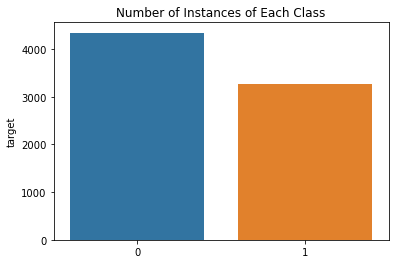

In [6]:
x = tweets.target.value_counts()
sns.barplot(x.index, x,).set(title="Number of Instances of Each Class")


## Part 2: Using Meta Features to Create a Baseline Classifier

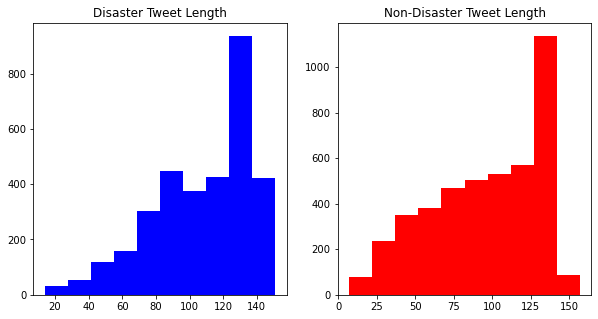

Disaster Tweets: 
Mean: 108.11342097217977
Standard Deviation: 29.30985431358517
Non-Disaster Tweets: 
Mean: 95.70681713496084
Standard Deviation: 35.88592390140908


In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
disaster_len = tweets[tweets['target']==1]['text'].str.len()
disaster_mean, disaster_std = disaster_len.mean(), disaster_len.std()
ax1.hist(disaster_len,color='blue')
ax1.set_title('Disaster Tweet Length')
nondisaster_len = tweets[tweets['target']==0]['text'].str.len()
nondisaster_mean, nondisaster_std = nondisaster_len.mean(), nondisaster_len.std()
ax2.hist(nondisaster_len, color='red')
ax2.set_title('Non-Disaster Tweet Length')
plt.show()

print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))

print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))

Disaster Tweets tend to be slightly longer than non-disaster tweets. This could be because disaster tweets are coming from professional sources and using more professional language than generic tweets.

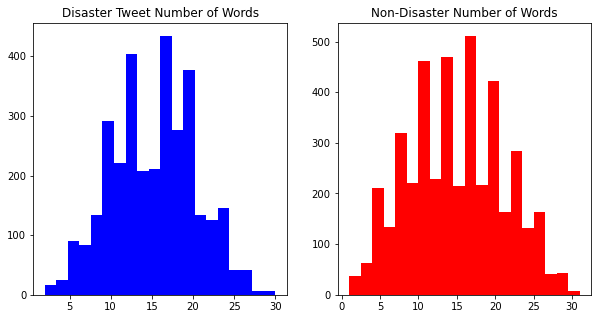

Disaster Tweets: 
Mean: 15.167532864567411
Standard Deviation: 5.096805739204259
Non-Disaster Tweets: 
Mean: 14.704744357438969
Standard Deviation: 6.1615635808192595


In [51]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))


disaster_words = tweets[tweets['target']==1]['text'].str.split().map(lambda x: len(x))
disaster_mean, disaster_std = disaster_words.mean(), disaster_words.std()
ax1.hist(disaster_words,color='blue',bins=20)
ax1.set_title('Disaster Tweet Number of Words')


nondisaster_words = tweets[tweets['target']==0]['text'].str.split().map(lambda x: len(x))
nondisaster_mean, nondisaster_std = nondisaster_words.mean(), nondisaster_words.std()
ax2.hist(nondisaster_words, color='red',bins=20)
ax2.set_title('Non-Disaster Number of Words')
plt.show()

print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))

print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))

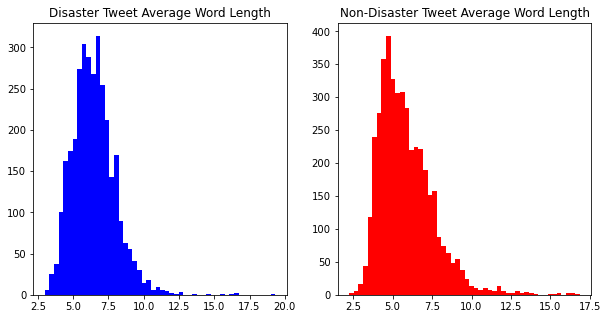

Disaster Tweets: 
Mean: 6.469866063188731
Standard Deviation: 1.5169374586061595

Non-Disaster Tweets: 
Mean: 5.8713247795406724
Standard Deviation: 1.742149940924163


In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

disaster_wordlength = tweets[tweets['target']==1]['text'].str.split().apply(lambda x : np.mean([len(i) for i in x]))
disaster_wordlengthmean, disaster_wordlengthstd = disaster_wordlength.mean(), disaster_wordlength.std()
ax1.hist(disaster_wordlength,color='blue', bins=50)
ax1.set_title('Disaster Tweet Average Word Length')

nondisaster_wordlength = tweets[tweets['target']==0]['text'].str.split().apply(lambda x : np.mean([len(i) for i in x]))
nondisaster_wordlengthmean, nondisaster_wordlengthstd = nondisaster_wordlength.mean(), nondisaster_wordlength.std()

ax2.hist(nondisaster_wordlength,color='red', bins=50)
ax2.set_title('Non-Disaster Tweet Average Word Length')
plt.show()

print("Disaster Tweets: ")
print("Mean: " + str(disaster_wordlengthmean))
print("Standard Deviation: " + str(disaster_wordlengthstd))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_wordlengthmean))
print("Standard Deviation: " + str(nondisaster_wordlengthstd))

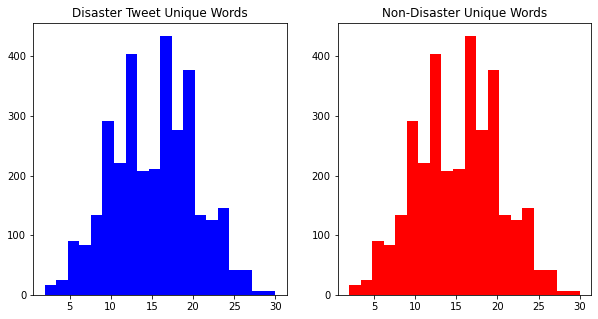

Disaster Tweets: 
Mean: 14.664934270865178
Standard Deviation: 4.710933601832796

Non-Disaster Tweets: 
Mean: 14.09649930907416
Standard Deviation: 5.654747824007804


In [53]:
# Unique Word Count

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
disaster_unique = tweets[tweets['target']==1]['text'].str.split().map(lambda x: len(set(x)))
disaster_mean, disaster_std = disaster_unique.mean(), disaster_unique.std()
ax1.hist(disaster_words,color='blue',bins=20)
ax1.set_title('Disaster Tweet Unique Words')

nondisaster_unique = tweets[tweets['target']==0]['text'].str.split().map(lambda x: len(set(x)))
nondisaster_mean, nondisaster_std = nondisaster_unique.mean(), nondisaster_unique.std()
ax2.hist(disaster_words,color='red',bins=20)
ax2.set_title('Non-Disaster Unique Words')

plt.show()
print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))

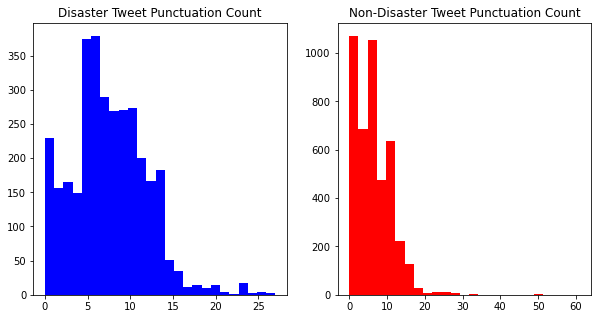

Disaster Tweets: 
Mean: 7.54356465912565
Standard Deviation: 4.195437380328195

Non-Disaster Tweets: 
Mean: 6.30907415937356
Standard Deviation: 4.830297304730791


In [23]:
## punctuation count - pretty big difference
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
disaster_punct = tweets[tweets['target']==1]['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
disaster_mean, disaster_std = disaster_punct.mean(), disaster_punct.std()
ax1.hist(disaster_punct,color='blue',bins=25)
ax1.set_title('Disaster Tweet Punctuation Count')

nondisaster_punct = tweets[tweets['target']==0]['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
nondisaster_mean, nondisaster_std = nondisaster_punct.mean(), nondisaster_punct.std()
ax2.hist(nondisaster_punct,color='red',bins=25)
ax2.set_title('Non-Disaster Tweet Punctuation Count')

plt.show()
print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))

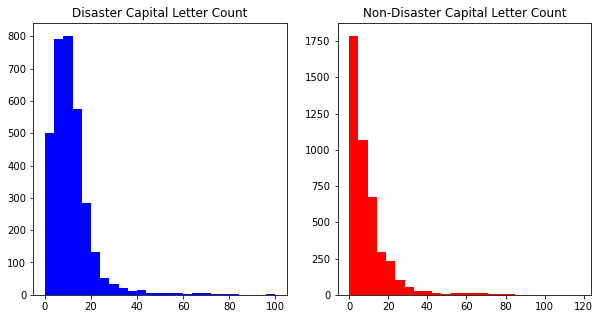

Disaster Tweets: 
Mean: 10.870681748700703
Standard Deviation: 9.61430983653719

Non-Disaster Tweets: 
Mean: 9.20935052970981
Standard Deviation: 10.962635755858244


In [24]:
# Number of Capital Characters

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
disaster_cap = tweets[tweets['target']==1]['text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))
disaster_mean, disaster_std = disaster_cap.mean(), disaster_cap.std()
ax1.hist(disaster_cap,color='blue',bins=25)
ax1.set_title('Disaster Capital Letter Count')

nondisaster_cap = tweets[tweets['target']==0]['text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))
nondisaster_mean, nondisaster_std = nondisaster_cap.mean(), nondisaster_cap.std()
ax2.hist(nondisaster_cap,color='red',bins=25)
ax2.set_title('Non-Disaster Capital Letter Count')

plt.show()
print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))

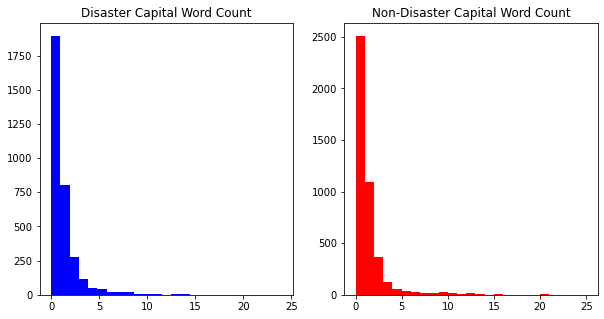

Disaster Tweets: 
Mean: 0.9012534393151941
Standard Deviation: 1.8524390782158864

Non-Disaster Tweets: 
Mean: 0.9585444495624136
Standard Deviation: 2.1222995226820647


In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

disaster_capwords = tweets[tweets['target']==1]['text'].str.split().apply(lambda x: len([s for s in x if s.isupper()]))
disaster_mean, disaster_std = disaster_capwords.mean(), disaster_capwords.std()
ax1.hist(disaster_capwords,color='blue',bins=25)
ax1.set_title('Disaster Capital Word Count')

nondisaster_capwords = tweets[tweets['target']==0]['text'].str.split().apply(lambda x: len([s for s in x if s.isupper()]))
nondisaster_mean, nondisaster_std = nondisaster_capwords.mean(), nondisaster_capwords.std()
ax2.hist(nondisaster_capwords,color='red',bins=25)
ax2.set_title('Non-Disaster Capital Word Count')

plt.show()                                                                      
print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))
                                                                          

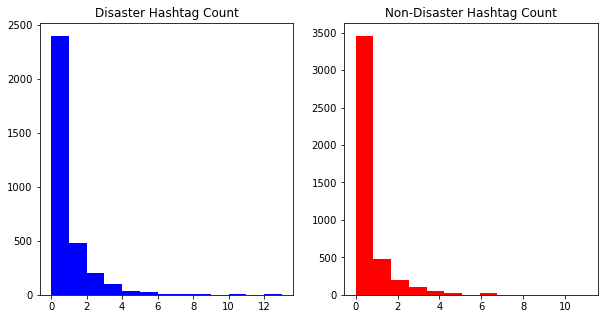

Disaster Tweets: 
Mean: 0.5206358911647814
Standard Deviation: 1.206805001280278

Non-Disaster Tweets: 
Mean: 0.391524643021649
Standard Deviation: 1.0084197607784438


In [10]:
# Number of Hashtags

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

disaster_hash = tweets[tweets['target']==1]['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
disaster_mean, disaster_std = disaster_hash.mean(), disaster_hash.std()
ax1.hist(disaster_hash,color='blue',bins=13)
ax1.set_title('Disaster Hashtag Count')

nondisaster_hash = tweets[tweets['target']==0]['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
nondisaster_mean, nondisaster_std = nondisaster_hash.mean(), nondisaster_hash.std()
ax2.hist(nondisaster_hash,color='red',bins=13)
ax2.set_title('Non-Disaster Hashtag Count')

plt.show()
print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))

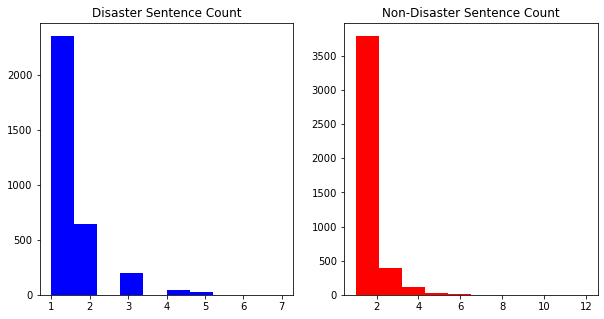

Disaster Tweets: 
Mean: 1.3952919596453683
Standard Deviation: 0.7468358322276965

Non-Disaster Tweets: 
Mean: 1.598802395209581
Standard Deviation: 0.8759913951151862


In [28]:
# Number of Sentences
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

disaster_sent = tweets[tweets['target']==1]['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
disaster_mean, disaster_std = disaster_sent.mean(), disaster_sent.std()
ax1.hist(disaster_sent,color='blue',bins=10)
ax1.set_title('Disaster Sentence Count')

nondisaster_sent = tweets[tweets['target']==0]['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
nondisaster_mean, nondisaster_std = nondisaster_sent.mean(), nondisaster_sent.std()
ax2.hist(nondisaster_sent,color='red',bins=10)
ax2.set_title('Non-Disaster Sentence Count')
plt.show()

print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))

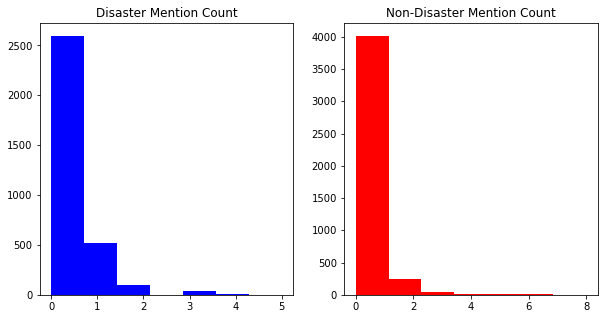

Disaster Tweets: 
Mean: 0.2766738000611434
Standard Deviation: 0.6296958663362244

Non-Disaster Tweets: 
Mean: 0.4269921695071396
Standard Deviation: 0.7751550539668309


In [29]:
# Mention Count

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

disaster_ment = tweets[tweets['target']==1]['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
disaster_mean, disaster_std = disaster_ment.mean(), disaster_ment.std()
ax1.hist(disaster_ment,color='blue',bins=7)
ax1.set_title('Disaster Mention Count')

nondisaster_ment = tweets[tweets['target']==0]['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
nondisaster_mean, nondisaster_std = nondisaster_ment.mean(), nondisaster_ment.std()
ax2.hist(nondisaster_ment,color='red',bins=7)
ax2.set_title('Non-Disaster Mention Count')

plt.show()
print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))

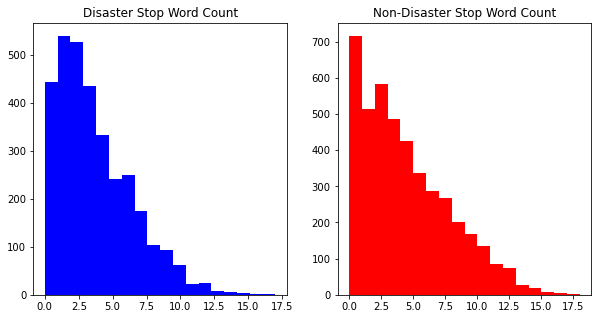

Disaster Tweets: 
Mean: 3.4481809844084377
Standard Deviation: 2.8872262530580803

Non-Disaster Tweets: 
Mean: 3.9758175955780746
Standard Deviation: 3.393981584982746


In [54]:
# Number of stopwords

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

disaster_stop = tweets[tweets['target']==1]['text'].str.split().apply(lambda x: len([s for s in x if s in stop]))
disaster_mean, disaster_std = disaster_stop.mean(), disaster_stop.std()
ax1.hist(disaster_stop,color='blue',bins=18)
ax1.set_title('Disaster Stop Word Count')

nondisaster_stop = tweets[tweets['target']==0]['text'].str.split().apply(lambda x: len([s for s in x if s in stop]))
nondisaster_mean, nondisaster_std = nondisaster_stop.mean(), nondisaster_stop.std()
ax2.hist(nondisaster_stop,color='red',bins=18)
ax2.set_title('Non-Disaster Stop Word Count')

plt.show()                                                                      
print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))
                                                       

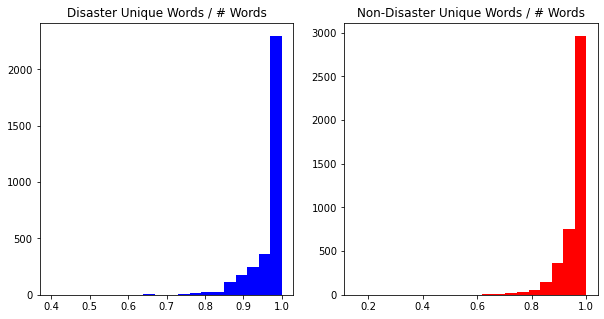

Disaster Tweets: 
Mean: 0.9735052493239087
Standard Deviation: 0.0495181086567404

Non-Disaster Tweets: 
Mean: 0.968347436030965
Standard Deviation: 0.0563260458296937


In [31]:
# Ratio of Unique Words to total number of words
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

disaster_uniquerate = disaster_unique / disaster_words
disaster_mean, disaster_std = disaster_uniquerate.mean(), disaster_uniquerate.std()
ax1.hist(disaster_uniquerate,color='blue',bins=20)
ax1.set_title('Disaster Unique Words / # Words')

nondisaster_uniquerate = nondisaster_unique / nondisaster_words
nondisaster_mean, nondisaster_std = nondisaster_uniquerate.mean(), nondisaster_uniquerate.std()
ax2.hist(nondisaster_uniquerate,color='red',bins=20)
ax2.set_title('Non-Disaster Unique Words / # Words')

plt.show()                                                                      
print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))

In [9]:
# Get rid of everything except the text
tweets = pd.read_csv('Data/train.csv')
labels = tweets['target']
tweets = tweets.drop(labels=["id", "keyword", "location", "target"], axis=1)
print(tweets.head(3))
print()
print(labels.head(3))


                                                text
0  Our Deeds are the Reason of this #earthquake M...
1             Forest fire near La Ronge Sask. Canada
2  All residents asked to 'shelter in place' are ...

0    1
1    1
2    1
Name: target, dtype: int64


In [10]:
# Let's use all these features to create a baseline classifier

tweets['tweet length'] = tweets['text'].str.len()
tweets['num words'] = tweets['text'].str.split().map(lambda x: len(x))
tweets['avg word length'] = tweets['text'].str.split().apply(lambda x : np.mean([len(i) for i in x]))
tweets['unique count'] = tweets['text'].str.split().map(lambda x: len(set(x)))
tweets['punct count'] = tweets['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
tweets['cap letter count'] = tweets['text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))
tweets['cap word count'] = tweets['text'].str.split().apply(lambda x: len([s for s in x if s.isupper()]))
tweets['hashtag count'] = tweets['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
tweets['sentence count'] = tweets['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
tweets['mention count'] = tweets['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
tweets['stop word count'] = tweets['text'].str.split().apply(lambda x: len([s for s in x if s in stop]))
tweets['unique ratio'] = tweets['unique count'] / tweets['num words']
                    
tweets = tweets.drop(labels=['text'], axis=1)
print(tweets.head(3))




   tweet length  num words  avg word length  unique count  punct count  \
0            69         13         4.384615            13            1   
1            38          7         4.571429             7            1   
2           133         22         5.090909            20            3   

   cap letter count  cap word count  hashtag count  sentence count  \
0                10               1              1               1   
1                 5               0              0               2   
2                 2               0              0               2   

   mention count  stop word count  unique ratio  
0              0                5      1.000000  
1              0                0      1.000000  
2              0                9      0.909091  


In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = tweets.to_numpy()
y = labels.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 

logisticRegression = SGDClassifier(loss='log', penalty='l2', alpha=0.0001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
logisticRegression.fit(X_train, y_train)
y_pred = logisticRegression.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy on testing set: ", accuracy)



Accuracy on testing set:  0.6585686145764937


## Part 3: Using more Complicated Features

In [86]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tweets = pd.read_csv('Data/train.csv')


def create_corpus(target):
    
    corpus=[]
    for x in tweets[tweets['target'] == target]['text'].str.split(): 
        for i in x:
            corpus.append(i)
    return corpus # returns a list of all words that are classified as disaster or non-disaster
    

corpus = create_corpus(0)

def create_wordbank(corpus): # input - corpus, output - set of words tupled with # of occurences
    wordbank = {}
    for word in corpus:
        if word not in stop: # stop is the nltk ignorewords pool
            if word in wordbank:
                wordbank[word] += 1
            else:
                wordbank[word] = 1
    return wordbank

def generate_scores(data, wordbank): # Each word's score is its frequency in either the disaster or nondisaster train set. Divide total score of all words in tweet by the number of words to get a score for each tweet
    scores = np.zeros(data.shape[0])
    for i,tweet in enumerate(data):
        words = nltk.word_tokenize(tweet)
        score = 0
        num_words = len(words)
        for word in words:
            if word in wordbank:
                score += wordbank[word]
        scores[i] = score / num_words
    return scores
            
        

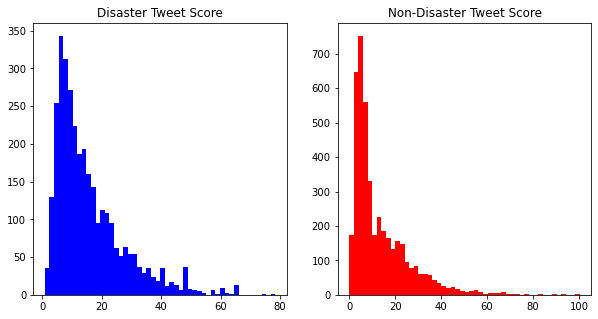

Disaster Tweets: 
Mean: 15.796904563845873
Standard Deviation: 11.624292022934304

Non-Disaster Tweets: 
Mean: 13.27856614874117
Standard Deviation: 12.352656288951852


In [87]:
# Disaster Score

corpus = create_corpus(1)
wordbank = create_wordbank(corpus)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

disaster_data = tweets[tweets['target']==1]['text'].to_numpy()
nondisaster_data = tweets[tweets['target']==0]['text'].to_numpy()

disaster_scores = generate_scores(disaster_data, wordbank)
disaster_mean, disaster_std = np.mean(disaster_scores), np.std(disaster_scores)

nondisaster_scores = generate_scores(nondisaster_data, wordbank)
nondisaster_mean, nondisaster_std = np.mean(nondisaster_scores), np.std(nondisaster_scores)


ax1.hist(disaster_scores,color='blue',bins=50)
ax1.set_title('Disaster Tweet Score')

ax2.hist(nondisaster_scores,color='red',bins=50)
ax2.set_title('Non-Disaster Tweet Score')

plt.show()

print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))

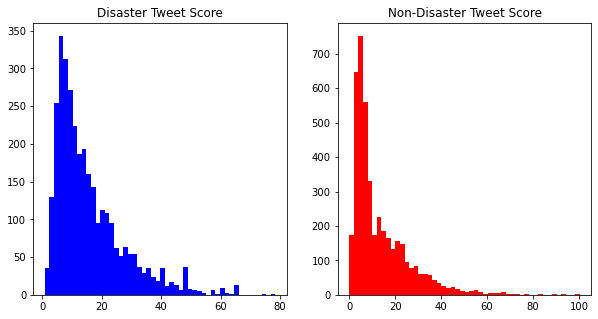

Disaster Tweets: 
Mean: 15.796904563845873
Standard Deviation: 11.624292022934304

Non-Disaster Tweets: 
Mean: 13.27856614874117
Standard Deviation: 12.352656288951852


In [88]:
# Non Disaster Score

corpus = create_corpus(0)
wordbank = create_wordbank(corpus)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

disaster_data = tweets[tweets['target']==1]['text'].to_numpy()
nondisaster_data = tweets[tweets['target']==0]['text'].to_numpy()

disaster_scores_ = generate_scores(disaster_data, wordbank)
disaster_mean, disaster_std = np.mean(disaster_scores), np.std(disaster_scores)

nondisaster_scores_ = generate_scores(nondisaster_data, wordbank)
nondisaster_mean, nondisaster_std = np.mean(nondisaster_scores), np.std(nondisaster_scores)


ax1.hist(disaster_scores,color='blue',bins=50)
ax1.set_title('Disaster Tweet Score')

ax2.hist(nondisaster_scores,color='red',bins=50)
ax2.set_title('Non-Disaster Tweet Score')

plt.show()

print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))

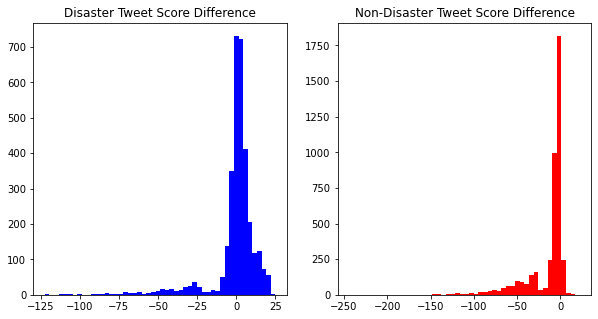

Disaster Tweets: 
Mean: -0.592924268734647
Standard Deviation: 15.203304903869434

Non-Disaster Tweets: 
Mean: -14.83754154311126
Standard Deviation: 25.24656160603047


In [96]:
# Disaster Score - Non-Disaster Score for each tweet
tweets = pd.read_csv('Data/train.csv')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

dis_corpus = create_corpus(1)
non_corpus = create_corpus(0)
dis_wordbank = create_wordbank(dis_corpus)
non_wordbank = create_wordbank(non_corpus)


disaster_data = tweets[tweets['target']==1]['text'].to_numpy()
nondisaster_data = tweets[tweets['target']==0]['text'].to_numpy()

disaster_scores = np.subtract(generate_scores(disaster_data, dis_wordbank), generate_scores(disaster_data, non_wordbank))
disaster_mean, disaster_std = np.mean(disaster_scores), np.std(disaster_scores)

nondisaster_scores = np.subtract(generate_scores(nondisaster_data, dis_wordbank), generate_scores(nondisaster_data, non_wordbank))
nondisaster_mean, nondisaster_std = np.mean(nondisaster_scores), np.std(nondisaster_scores)


ax1.hist(disaster_scores,color='blue',bins=50)
ax1.set_title('Disaster Tweet Score Difference')

ax2.hist(nondisaster_scores,color='red',bins=50)
ax2.set_title('Non-Disaster Tweet Score Difference')

plt.show()

print("Disaster Tweets: ")
print("Mean: " + str(disaster_mean))
print("Standard Deviation: " + str(disaster_std))
print()
print("Non-Disaster Tweets: ")
print("Mean: " + str(nondisaster_mean))
print("Standard Deviation: " + str(nondisaster_std))

In [97]:
tweets = pd.read_csv('Data/train.csv')
labels = tweets['target']

non_corpus = create_corpus(0)
non_wordbank = create_wordbank(non_corpus)
nondisaster_scores = generate_scores(tweets['text'].to_numpy(), non_wordbank)


dis_corpus = create_corpus(1)
dis_wordbank = create_wordbank(dis_corpus)
disaster_scores = generate_scores(tweets['text'].to_numpy(), dis_wordbank)

scores_diff = np.subtract(disaster_scores, nondisaster_scores)

tweets = tweets.drop(labels=["id", "keyword", "location", "target"], axis=1)
tweets['tweet length'] = tweets['text'].str.len()
tweets['num words'] = tweets['text'].str.split().map(lambda x: len(x))
tweets['avg word length'] = tweets['text'].str.split().apply(lambda x : np.mean([len(i) for i in x]))
tweets['unique count'] = tweets['text'].str.split().map(lambda x: len(set(x)))
tweets['punct count'] = tweets['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
tweets['cap letter count'] = tweets['text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))
tweets['cap word count'] = tweets['text'].str.split().apply(lambda x: len([s for s in x if s.isupper()]))
tweets['hashtag count'] = tweets['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
tweets['sentence count'] = tweets['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
tweets['mention count'] = tweets['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
tweets['stop word count'] = tweets['text'].str.split().apply(lambda x: len([s for s in x if s in stop]))
tweets['unique ratio'] = tweets['unique count'] / tweets['num words']
tweets['disaster scores'] = disaster_scores
tweets['nondisaster scores'] = nondisaster_scores
tweets['score diff'] = scores_diff
tweets = tweets.drop(labels=['text'], axis=1)

print(tweets.head(3))

   tweet length  num words  avg word length  unique count  punct count  \
0            69         13         4.384615            13            1   
1            38          7         4.571429             7            1   
2           133         22         5.090909            20            3   

   cap letter count  cap word count  hashtag count  sentence count  \
0                10               1              1               1   
1                 5               0              0               2   
2                 2               0              0               2   

   mention count  stop word count  unique ratio  disaster scores  \
0              0                5      1.000000         4.214286   
1              0                0      1.000000        25.000000   
2              0                9      0.909091         5.791667   

   nondisaster scores  score diff  
0            4.714286   -0.500000  
1            7.750000   17.250000  
2            5.000000    0.791667  


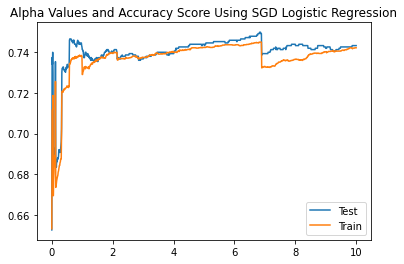

Best Accuracy: 0.7498358502954695
Best Alpha: 6.826829999999999


In [101]:
X = tweets.to_numpy()
y = labels.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scores_test = []
scores_train = []
alphas = np.linspace(0.00001, 10, 1000)


for alpha in alphas:
    logisticRegression = SGDClassifier(loss='log', penalty='l2', alpha=alpha, max_iter=1000, shuffle=True, verbose=0, random_state=42)
    logisticRegression.fit(X_train, y_train)
    
    y_pred_train = logisticRegression.predict(X_train)
    y_pred_test = logisticRegression.predict(X_test)
    
    scores_train.append(accuracy_score(y_pred_train, y_train))
    scores_test.append(accuracy_score(y_pred_test, y_test))

plt.plot(alphas, scores_test, label="Test")
plt.plot(alphas, scores_train, label="Train")

plt.title("Alpha Values and Accuracy Score Using SGD Logistic Regression")
plt.legend()
plt.show()
print("Best Accuracy: " + str(max(scores_test)))
print("Best Alpha: " + str(alphas[scores_test.index(max(scores_test))]))


In [ ]:
from sklearn.ensemble import AdaBoostClassifier


scores_test = []
scores_train = []

num_estimators = np.linspace(5, 1000, 5, dtype=int)
for n in num_estimators:
    ada = AdaBoostClassifier(n_estimators=n, random_state=42)
    ada.fit(X_train, y_train)
    
    y_pred_train = ada.predict(X_train)
    y_pred_test = ada.predict(X_test)
    
    scores_train.append(accuracy_score(y_pred_train, y_train))
    scores_test.append(accuracy_score(y_pred_test, y_test))
    
    
    
plt.plot(num_estimators, scores_test, label="Test")
plt.plot(num_estimators, scores_train, label="Train")
plt.title("Number of Estimators and Accuracy Score Using AdaBoost")
plt.legend()
plt.show()
print("Best Accuracy: " + str(max(scores_test)))
print("Best Number of Estimators: " + str(num_estimators[scores_test.index(max(scores_test))]))